# Week 3: Fitting

In many different cases, we might have a model for how a system works, and want to fit that model to a set of observations. 

We're going to investigate the process of fitting using a classic paper that proposed a model for the [T cell receptor](https://www.ncbi.nlm.nih.gov/pubmed/11606269). Here, the authors develop a mathematical model for how binding occurs and then have observations of how much binding occurs under specific conditions. Identifying whether and how this model fits has led to a better understanding of how our immune system utilizes antibodes, and efforts to design antibodies that function more potently.

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.special import binom
from scipy.optimize import brentq

np.seterr(over='raise')

def StoneMod(Rtot, Kd, v, Kx, L0):
    '''
    Returns the number of mutlivalent ligand bound to a cell with Rtot
    receptors, granted each epitope of the ligand binds to the receptor
    kind in question with dissociation constant Kd and cross-links with
    other receptors with crosslinking constant Kx. All eq derived from Stone et al. (2001).
    '''
    v = np.int_(v)
    
    # Mass balance for receptor species, to identify the amount of free receptor
    diffFunAnon = lambda x: Rtot-x*(1+v*L0*(1/Kd)*(1+Kx*x)**(v-1))
    
    # Check that there is a solution
    if diffFunAnon(0) * diffFunAnon(Rtot) > 0:
        raise RuntimeError("There is no solution with these parameters. Are your inputs correct?")

    # Vector of binomial coefficients
    Req = brentq(diffFunAnon, 0, Rtot, disp=False)

    # Calculate vieq from equation 1
    vieq = L0*(1/Kd)*Req*(binom(v, np.arange(1, v + 1))) * np.power(Kx*Req, np.arange(v))

    # Calculate L, according to equation 7
    Lbound = np.sum(vieq)

    # Calculate Rmulti from equation 5
    Rmulti = np.sum(np.multiply(vieq[1:], np.arange(2, v + 1, dtype=np.float)))

    # Calculate Rbound
    Rbnd = np.sum(np.multiply(vieq, np.arange(1, v + 1, dtype=np.float)))

    return (Lbound, Rbnd, Rmulti)

data = np.loadtxt("wk3-stone.csv", delimiter=",")

# Vector of the ligand concentrations, cell response (proportional to Rmulti), valencies
Xs, Ys, Vs = np.hsplit(data, 3)

Xs = np.squeeze(Xs)
Ys = np.squeeze(Ys)
Vs = np.squeeze(Vs)

#### (1) We will fit the data contained within Fig. 3B. Plot this data and describe the relationship you see between Kx, Kd, and valency.

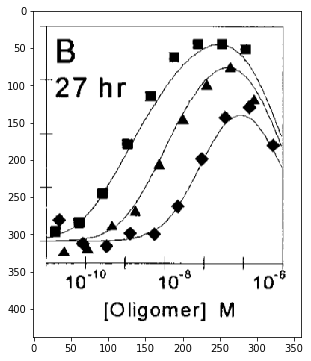

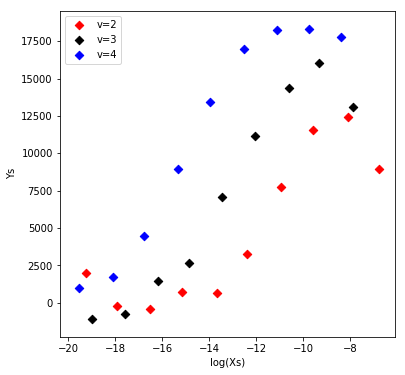

In [96]:
# Answer
import matplotlib.image as mplimg

# Show Fig 3B from Stone et al.
plt.figure(figsize =(6, 6))
im_path = 'Stone et al. Fig 3B.png'
fig3 = mplimg.imread(im_path)
plt.imshow(fig3)

# Create ranges for valencies
v2Range = range(0, 10)
v3Range = range(10, 19)
v4Range = range(19, 28)

# Scatter plot the measurements in .csv
plt.figure(figsize =(6, 6))
plt.scatter(np.log(200*Xs[v2Range]), 0.99*Ys[v2Range], marker='D', c='r', label = "v=2")
plt.scatter(np.log(200*Xs[v3Range]), 0.99*Ys[v3Range], marker='D', c='k', label = "v=3")
plt.scatter(np.log(200*Xs[v4Range]), 0.99*Ys[v4Range], marker='D', c='b', label = "v=4")

plt.legend()
plt.xlabel("log(Xs)")
plt.ylabel("Ys")

plt.show()


#### As the valency number increases the Kd value appears to decrease as more oligomers are bound per cell. The Kx value appears to increase as well.

#### (2) First, to do so, we'll need a function that takes the model predictions, scales them to the units of the actual measurements, and finds the predictions for each condition. Define a scaling parameter and a function that takes it along with the other parameters to make predictions about the experiment.

Use the fit parameters shown in Table 1 (row 2) and overlay with the measurements to ensure your function is working. (Scale = 1 for now.)

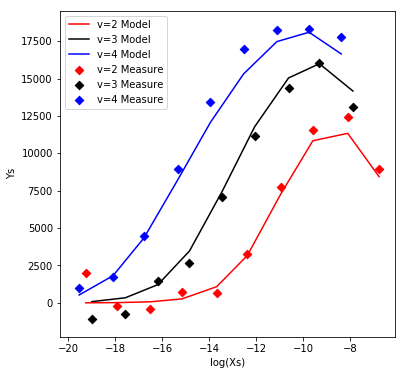

In [29]:
# Answer
Kd = 1.70 * 10**(-6)
Kx = 3.15 * 10**(-4)
Rtot = 24000
scale = 1

# Initializes array for storing the scaled Ys
scaledYs = np.zeros(len(Ys))

# Define function to return scaled model Rmulti value proposed by Stone et al.
def scaledYStoneMod(Rtot, Kd, v, Kx, L0, scale):
    x = StoneMod(Rtot, Kd, v, Kx, L0)
    Rmulti = x[2]
    return (Rmulti * scale)

# Create array with scaled Ys
def scaledYsStoneMod(Rtot, Kd, v, Kx, L0, scale):
    scYs = np.zeros(len(L0))
    assert(len(scYs) == len(L0))
    for i in range (0, len(L0)):
        scYs[i] = scaledYStoneMod(Rtot, Kd, Vs[i], Kx, L0[i], scale)
    return scYs

scaledYs = scaledYsStoneMod(Rtot, Kd, Vs, Kx, Xs, scale)

# Plot the scaled model along with scatter of measurements
plt.figure(figsize = (6, 6))
plt.scatter(np.log(200*Xs[v2Range]), 0.99*Ys[v2Range], marker='D', c='r', label = "v=2 Measure")
plt.plot(np.log(200*Xs[v2Range]), 0.99*scaledYs[v2Range], c='r', label = "v=2 Model")
plt.scatter(np.log(200*Xs[v3Range]), 0.99*Ys[v3Range], marker='D', c='k', label = "v=3 Measure")
plt.plot(np.log(200*Xs[v3Range]), 0.99*scaledYs[v3Range], c='k', label = "v=3 Model")
plt.scatter(np.log(200*Xs[v4Range]), 0.99*Ys[v4Range], marker='D', c='b', label = "v=4 Measure")
plt.plot(np.log(200*Xs[v4Range]), 0.99*scaledYs[v4Range], c='b', label = "v=4 Model")

plt.legend()
plt.xlabel("log(Xs)")
plt.ylabel("Ys")

plt.show()


#### Solid lines represent the model output of the scaled Ys. The markers are from the data from the csv file.

#### (2) Now use `scipy.optimize.least_squares` to find the least squares solution.

In [30]:
import scipy as sp

Kd = 1.70 * 10**(-6)
Kx = 3.15 * 10**(-4)
Rtot = 24000
scale = 1

# Create array for parameters that can be tuned during least squares
params = np.array([Kd, Kx, scale])

assert(params[0] == Kd)
assert(params[1] == Kx)
assert(params[2] == scale)

# Define function to calculate y errors between model and measurements
def residuals(params, Rtot, Vs, Xs, Ys):
    assert(len(Vs) == len(Xs) == len(Ys))
    predYs = scaledYsStoneMod(Rtot, params[0], Vs, params[1], Xs, params[2])
    return Ys - predYs

# Determine least squares solution and print
def ls(residuals, params, args):
    LSqVals = sp.optimize.least_squares(residuals, params, bounds=(0, np.inf), args=args)
    return LSqVals.x

# Assign variables to optimized Kd, Kx, and scale values
optParams = ls(residuals, params, args = (Rtot, Vs, Xs, Ys))

# Print optimized parameters
print('Kd =', optParams[0])
print('Kx =', optParams[1])
print('scale =', optParams[2])

Kd = 1.7026818013710686e-06
Kx = 0.0003147275129556619
scale = 1.0281519230341503


#### (3) Using leave-one-out crossvalidation, does this model predict the data? Plot the measured vs. predicted data.

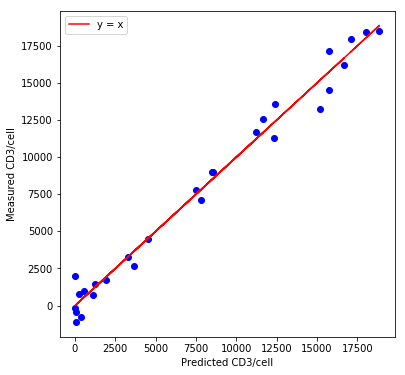

In [97]:
# Answer
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

# Creat arrays for train and test sets to be stored
# [iteration, value, variable]
# variables = [Xs, Ys, Vs]
trainSets = np.zeros((3, len(Xs) - 1))
testSets = np.zeros(3)
predYs = np.zeros(len(Ys))
testYs = np.zeros(len(Ys))

# Iterate through test and train sets
for train, test in loo.split(Xs):
    # Insert LS function to creat new model for each iteration
    # Stores train data for each Xs, Ys, Vs in train set
    trainSets[0] = Xs[train]
    trainSets[1] = Ys[train]
    trainSets[2] = Vs[train]
    
    # Stores test data for each Xs, Ys, Vs in test set
    testSets[0] = Xs[test]
    testSets[1] = Ys[test]
    testSets[2] = Vs[test]

    # Use least squares on train set to find beta
    looBeta = np.zeros(len(params))
    
    assert(len(trainSets[0]) == len(Xs) - 1)
    assert(len(trainSets[1]) == len(Ys) - 1)
    assert(len(trainSets[2]) == len(Vs) - 1)
    
    looBeta = ls(residuals, np.array([Kd, Kx, scale]), args = (Rtot, trainSets[2], trainSets[0], trainSets[1]))
    
#     print("---", test, "---")
#     print(beta)
    
    predYs[test] = scaledYStoneMod(Rtot, looBeta[0], Vs[test], looBeta[1], Xs[test], looBeta[2])
    testYs[test] = testSets[1]
    
plt.figure(figsize = (6, 6))
plt.scatter(predYs, testYs, c = 'b')
plt.plot(predYs, predYs, c = 'r', label = "y = x")

plt.legend()
plt.xlabel("Predicted CD3/cell")
plt.ylabel("Measured CD3/cell")

plt.show()

#### When plotting the predicted CD3/cell value based on the training set versus the measured CD3/cell value from the test set, the values appear to match each other and line up with the y = x plot. Therefore, the model predicts the data well as demonstrated with cross validation.

#### (4) Using bootstrap estimation, plot the confidence interval of the model along with the data points.

std(Kd) = 6.483066603881463e-07
std(Kx) = 0.018521001351058032
std(scale) = 566.3404370403314
cv(Kd) = 6.483066603881464e-08
cv(Kx) = 0.0018521001351058033
cv(scale) = 56.63404370403314


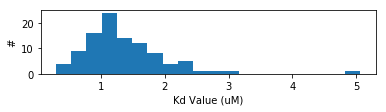

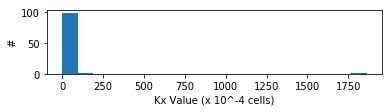

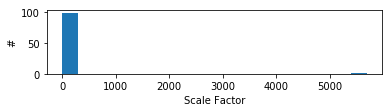

In [99]:
# Answer
from sklearn.utils import resample

Kd = 1.70 * 10**(-6)
Kx = 3.15 * 10**(-4)
Rtot = 24000
scale = 1

numBoots = 100

# [Kd, Kx, scale]
bootParams = np.zeros((numBoots, 3))

for i in range (0, numBoots):
    XsIndices = range(0, Xs.shape[0])
    resamp = resample(XsIndices)
    
    # Set up vectors of Xs, Ys, and Vs for current bootstrap
    XsBoot = Xs[resamp]
    YsBoot = Ys[resamp]
    VsBoot = Vs[resamp]
    
    # Run least squares on current bootstrap
    beta = ls(residuals, params, args = (Rtot, VsBoot, XsBoot, YsBoot))
#     print("---", i, "---")
#     print(beta)
    
    # Save Kd, Kx, and scale from current bootstrap
    bootParams[i] = beta

    
# Print standard deviations
print('std(Kd) =', np.std(bootParams[:, 0]))
print('std(Kx) =', np.std(bootParams[:, 1]))
print('std(scale) =', np.std(bootParams[:, 2]))

print('cv(Kd) =', np.std(bootParams[:, 0]) / np.sqrt(numBoots))
print('cv(Kx) =', np.std(bootParams[:, 1]) / np.sqrt(numBoots))
print('cv(scale) =', np.std(bootParams[:, 2]) / np.sqrt(numBoots))
    
# Plot histogram for Kd
plt.subplot(311)
plt.hist(bootParams[:, 0]*(10**6), 20)
plt.ylabel('#')
plt.xlabel('Kd Value (uM)')
plt.show()

# Plot histogram for Kx
plt.subplot(312)
plt.hist(bootParams[:, 1]*(10**4), 20)
plt.ylabel('#')
plt.xlabel('Kx Value (x 10^-4 cells)')
plt.show()

# Plot histogram for scale
plt.subplot(313)
plt.hist(bootParams[:, 2], 20)
plt.ylabel('#')
plt.xlabel('Scale Factor')
plt.show()

# cv = std/sqrt(numBoots)

#### (5) Now, we will perform a local sensitivity analysis to look at the dependence of the model results on each parameter. Vary each parameter up and down by 10-fold **while holding the others constant**, and plot the sum of squared error. Which parameter influences the fit the most? Which one the least?

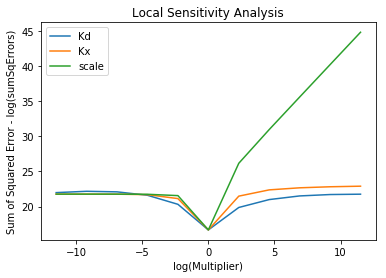

In [131]:
# Answer
# Create array for multipliers to vary parameters
multipliers = np.zeros(11)
multipliers = np.logspace(-5, 5, len(multipliers))
    
# Stores optimal value of Kd, Kx, and scale along with the 10-fold variations
varyParams = np.zeros((3, len(multipliers)))
for i in range(0, len(optParams)):
    varyParams[i] = np.dot(optParams[i], multipliers)

# Make function that returns the sum squared error for set of parameters
def sumSqEr(residuals, resParams, Rtot, Vs, Xs, Ys):
    res = residuals([resParams[0], resParams[1], resParams[2]], Rtot, Vs, Xs, Ys)
    return np.sum(res**2)

# Create matrix to store all sum squared errors
sumSqErrorsVaryOne = np.zeros(varyParams.shape)

# Use sumSqEr function to calculate error while sweeping through each parameter
for i in range(0, len(multipliers)):
    sumSqErrorsVaryOne[0, i] = sumSqEr(residuals, [varyParams[0, i], optParams[1], optParams[2]], Rtot, Vs, Xs, Ys)
    sumSqErrorsVaryOne[1, i] = sumSqEr(residuals, [optParams[0], varyParams[1, i], optParams[2]], Rtot, Vs, Xs, Ys)
    sumSqErrorsVaryOne[2, i] = sumSqEr(residuals, [optParams[0], optParams[1], varyParams[2, i]], Rtot, Vs, Xs, Ys)

# Plot sum of square of residuals versus each varied parameter
plt.plot(np.log(multipliers), np.log(sumSqErrorsVaryOne[0]))
plt.plot(np.log(multipliers), np.log(sumSqErrorsVaryOne[1]))
plt.plot(np.log(multipliers), np.log(sumSqErrorsVaryOne[2]))

plt.ylabel("Sum of Squared Error - log(sumSqErrors)")
plt.xlabel('log(Multiplier)')
plt.title('Local Sensitivity Analysis')
plt.legend(labels = ['Kd', 'Kx', 'scale'])
plt.show()


#### The Kd value seems to affect the sum of squared error the least, while the scale value had the greatest affect on the sum of squared error.

#### (6) While easier to perform, a local sensitivity analysis ignores codependency between the parameters. Do you anticipate your predictions of the parameter values will be more or less specified with a global analysis?

#### I expect the predictions or parameter values obtained with a global sensitivity test to be more specific. Becuase the parameters my have codependencies, only varying one parameter at a time hinders the ability to observe this behavior. For example, when parameter a and b are both equal to a value x the error is at a minimum. But if the 'a' value is fixed at a value other than the x value, the 'b' value may be determined to be optimal at another value.

#### (7) Now, vary each parameter from the optimal solution, *allowing the other parameters to vary*. Was your prediction true? How might the other parameters be varying when $K_d$ increases?

Hint: Probably the easiest way to do this is mess with the bounds of the least squares solver.

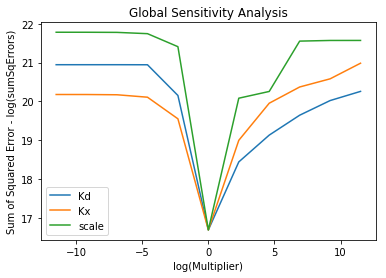

In [160]:
# Answer
sumSqErrorsVaryAll = np.zeros(varyParams.shape)
guessParams = optParams
errorParams = np.dot(optParams, 10E-15)

# Loop to vary Kd
for i in range(0, len(multipliers)):
    guessParams[0] = varyParams[0, i]
    lowerKd = optParams[0] - errorParams[0]
    upperKd = optParams[0] + errorParams[0]
    lsKd = sp.optimize.least_squares(residuals, guessParams, bounds = ([lowerKd, 0, 0], [upperKd, np.inf, np.inf]), args = (Rtot, Vs, Xs, Ys))
    betaKd = lsKd.x
    sumSqErrorsVaryAll[0, i] = sumSqEr(residuals, betaKd, Rtot, Vs, Xs, Ys)

# Loop to vary Kx
guessParams = optParams
for i in range(0, len(multipliers)):
    guessParams[1] = varyParams[1, i]
    lowerKx = optParams[1] - errorParams[1]
    upperKx = optParams[1] + errorParams[1]
    lsKx = sp.optimize.least_squares(residuals, guessParams, bounds = ([0, lowerKx, 0], [np.inf, upperKx, np.inf]), args = (Rtot, Vs, Xs, Ys))
    betaKx = lsKx.x
    sumSqErrorsVaryAll[1, i] = sumSqEr(residuals, betaKx, Rtot, Vs, Xs, Ys)

# Loop to vary scale
guessParams = optParams
for i in range(0, len(multipliers)):
    guessParams[2] = varyParams[2, i]
    lowerScale = optParams[2] - errorParams[2]
    upperScale = optParams[2] + errorParams[2]
    lsScale = sp.optimize.least_squares(residuals, guessParams, bounds = ([0, 0, lowerScale], [np.inf, np.inf, upperScale]), args = (Rtot, Vs, Xs, Ys))
    betaScale = lsScale.x
    sumSqErrorsVaryAll[2, i] = sumSqEr(residuals, betaScale, Rtot, Vs, Xs, Ys)
    
# Plot sum of square of residuals versus each varied parameter
plt.plot(np.log(multipliers), np.log(sumSqErrorsVaryAll[0]))
plt.plot(np.log(multipliers), np.log(sumSqErrorsVaryAll[1]))
plt.plot(np.log(multipliers), np.log(sumSqErrorsVaryAll[2]))

plt.ylabel("Sum of Squared Error - log(sumSqErrors)")
plt.xlabel('log(Multiplier)')
plt.title('Global Sensitivity Analysis')
plt.legend(labels = ['Kd', 'Kx', 'scale'])
plt.show()

#### My prediction was true: using a global sensitivty analysis will yield mre specified results. For example, we notice that when scale increases, the sum of error squared increases exponentially in the local analysis. However, in the global analysis, the sum of error plateaus off because Kd and Kx are allowed to vary from the "optimal" value to adjust for the varying scale.

#### (8) At the same time as providing the number of multimerized receptors, the model also infers the quantities of other properties, such as the amount of ligand and receptor bound. Using the bootstrap estimates, plot the confidence in these other parameters. Are these more or less exactly specified than Rmulti? *In general*, which sort of quantities do you think will be most exactly predicted?

std(Lbound) = 4512596.681292825
cv(Lbound) =  85280.06132740152
std(Rbnd) = 4513054.526292986
cv(Rbnd) =  85288.71378461181
std(Rmulti) = 6238.428280903104
cv(Rmulti) =  117.89521287987004


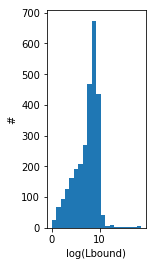

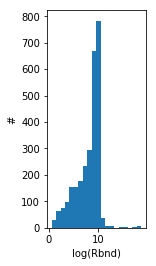

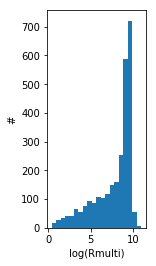

In [130]:
# Answer
# Function to return all the other return vals of the model scaled
def scaledStoneMod(Rtot, Kd, v, Kx, L0, scale):
    x = StoneMod(Rtot, Kd, v, Kx, L0)
    return np.dot(x, scale)

# Arrays to store the other parameters
scaledLbounds = []
scaledRbnds = []
scaledRmultis = []

# Calculate the other returned values using the different betas from boot strap for each data point
for i in range(0, numBoots):
    for j in range(0, len(Xs)):
        x = scaledStoneMod(Rtot, bootParams[i, 0], Vs[j], bootParams[i, 1], Xs[j], bootParams[i, 2])
        scaledLbounds.append(x[0])
        scaledRbnds.append(x[1])
        scaledRmultis.append(x[2])
        
# Print standard of Lbounds
print('std(Lbound) =', np.std(scaledLbounds))
print('cv(Lbound) = ', np.std(scaledLbounds)/np.sqrt(len(scaledLbounds)))  
# Print standard of Rbnds
print('std(Rbnd) =', np.std(scaledRbnds))
print('cv(Rbnd) = ', np.std(scaledRbnds)/np.sqrt(len(scaledRbnds)))  
# Print standard of Rmultis
print('std(Rmulti) =', np.std(scaledRmultis))
print('cv(Rmulti) = ', np.std(scaledRmultis)/np.sqrt(len(scaledRmultis))) 

    
# Plot confidence and print standard deviation of Lbounds
plt.subplot(131)
plt.hist(np.log(scaledLbounds), 20)
plt.ylabel('#')
plt.xlabel('log(Lbound)')
plt.show()

# Plot confidence and print standard deviation of Rbnds
plt.subplot(132)
plt.hist(np.log(scaledRbnds), 20)
plt.ylabel('#')
plt.xlabel('log(Rbnd)')
plt.show()
  
# Plot confidence and print standard deviation of Rmultis
plt.subplot(133)
plt.hist(np.log(scaledRmultis), 20)
plt.ylabel('#')
plt.xlabel('log(Rmulti)')
plt.show()


#### When analyzing the histograms it appears that log of the Rumulti varies in value between 0 and 10 while that of Rbnd and Lbound are varied slightly more. Additionally, the cv and std for the Lbound and Rbnd values are greater than that of Rmulti. The values most easily predicted are those with the smallest variance. Therefore, based on the histograms and standard deviations, Rmulti is less predictable than Lbound and Rbnd.

#### (9) Other quantities such as the number of bound receptors may be possible to measure as well. Describe how you would go about fitting this data along with the multimerized receptor measurements. How might more measurements of different types be better than more measurements of the same type?

Answer.

#### Ideally, we would have an infinite number of measurements to train our model off of in an effort to minimize the prediction error. However, when we introduce the additional variables we encounter the issue of making our model more complex and in cause, increasing our prediction error (bias-variance trade off). If we introduce too much variance into the model we will lose value in the predicted values yielded by the model. However, in this homework we validated our model using leave one out and bootstrap cross validation methods. Using these cross validation methods would be an acceptable way to measure the validity of the model.

#### We would want to introduce the new measurements because it would make our model better, but we need to be aware of how much our prediction error increases as we introduce these measurements. The method to implement this would be to start by adapting the current Stone et al. model to take the new measurements as inputs. Then we follow the same process we did with the creating a function to calculate the fitting error between the model and date and use least squares to minimize this. Then use leave one out and bootstrap to validate the ouputed model. We could use both of these methods to calculate our prediction error between the model and the measured values. As we introduce more variables we would expect our model to increase in prediction error, so we would want to set a threshold accuracy to indicate when we should stop incorporating more measurements of different types. 